# 📘 Mnist Classifier From Scratch -EN
---

This notebook provides a **hands-on implementation of a Deep Neural Network (DNN)** from scratch using NumPy. Instead of relying on high-level libraries like TensorFlow or PyTorch, this exercise focuses on building the core components manually to better understand how neural networks function under the hood — including forward pass, backward pass, weight updates, and training loops.

## Table of Contents

- [1. Download Mnist Dataset and Unzip](#1-download-mnist-dataset-and-unzip)
- [2. Preprocess the Data](#2-preprocess-the-data)
- [3. Split Dataset to Training and Testing](#3-split-dataset-to-training-and-testing)
- [4. Define Activation Functions](#4-define-activation-functions)
- [5. Define Loss Function and Metrics](#5-define-loss-function-and-metrics)
- [6. Define Layer Class](#6-define-layer-class)
- [7. Define Model Class](#7-define-model-class)
- [8. Build Model Object](#8-build-model-object)
- [9. Train Model](#9-train-model)
- [10. Build Confusion Matrix](#10-build-confusion-matrix)

In [1]:
import os
import requests
import gzip
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

## 1. Download Mnist Dataset and Unzip
---

The **MNIST**(Modified National Insitute of Standard and Technology) database is a large collection of handwritten digits. MNIST itself contains 60000 images for the training set and 10000 images for the testing set. In the dataset, the digits have been size-normalized and centered in a fixed-size image of size 28x28. 

In [2]:
# https://github.com/cvdfoundation/mnist?tab=readme-ov-file
DATA_DIR = "/app/dataset/MNIST"
os.makedirs(DATA_DIR, exist_ok=True)

In [3]:

def download_mnist():
    MNIST_FILES = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
    }
    for name, url in MNIST_FILES.items():
        out_path = os.path.join(DATA_DIR, url.split('/')[-1])
        result_path = out_path[:-3] 
        if not os.path.exists(result_path):
            if not os.path.exists(out_path):
                print(f"Downloading {name}...")
                r = requests.get(url)
                with open(out_path, 'wb') as f:
                    f.write(r.content)
            else:
                print(f"{name} already downloaded.")
            print(f"Unzipping {out_path}...")
            with gzip.open(out_path, 'rb') as f_in:
                with open(result_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        
        else:
            print(f"{name} already unzipped.")

In [4]:
download_mnist()

train_images already unzipped.
train_labels already unzipped.
test_images already unzipped.
test_labels already unzipped.


In [5]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    print(folder + "/" + prefix + '-images-idx3-ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "/app/dataset/MNIST" )
testImages, testLabels = loadMNIST( "t10k", "/app/dataset/MNIST" )

/app/dataset/MNIST/train-images-idx3-ubyte
/app/dataset/MNIST/t10k-images-idx3-ubyte


## 2. Preprocess the Data
---

To prepare the Mnist data for training a neural network, two preprocessing steps are applied:

- **Normalize Pixel Values**: Pixel values in images typically range from 0 to 255. These values are normalized to a range of 0 to 1 by dividing each pixel by 255. This helps the network train more effectively.

- **One-hot Encode Labels**: Labels are converted to one-hot encoded vectors to represent categorical classes in a format the neural network can understand. In one hot vectors, each category is represented by a vector (array) of $N$ elements, where $N$ is the number of categories.
![One hot vector representation](https://developers.google.com/static/machine-learning/crash-course/images/vocabulary-index-sparse-feature.svg)


In [6]:
def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

In [7]:
X_train = trainingImages / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = testImages / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = toHotEncoding( trainingLabels )
y_test = toHotEncoding( testLabels )

### 2.1 Show Sample image from the dataset
To better understand the structure and appearance of a single Mnist Image, it can be visualized with matplotlib. This helps in getting familiar with when working with the data.

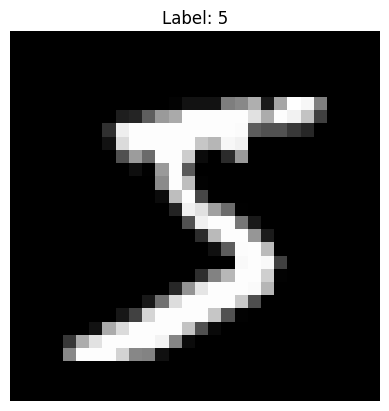

In [8]:
i = 0

image = trainingImages[i]  
label = trainingLabels[i]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## 3. Split Dataset to Training and Testing
---

After preprocessing, the dataset is **shuffled** to ensure that the training and testing sets are representative of the overall data distribution. Once shuffled, the dataset is **split** into 80% for training and 20% for testing, helping to evaluate the model's performance on unseen data.

In [9]:
# Uncomment if want a 48k:12k split manually
# Shuffle the training set randomly
indices = np.random.permutation(X_train.shape[0])
X_train = X_train[indices]
y_train = y_train[indices]

# Split the training and testing data to a 80:20 ratio
split_index = int(X_train.shape[0] * 0.8)
X_test = X_train[split_index:]
y_test = y_train[split_index:]
X_train = X_train[:split_index]
y_train = y_train[:split_index]

# Uncomment if want to split using sklearn
# from sklearn.model_selection import train_test_split    
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, shuffle=True
# )

# print out the shape of each
# The training image set has 60000 images with 784 columns(each image is 28x28, flattened, 784)
# The training image labels has 60000 labels with 10 columns

print(f"{X_train.shape}:{y_train.shape}")
print(f"{X_test.shape}:{y_test.shape}")

(48000, 784):(48000, 10)
(12000, 784):(12000, 10)


## 4. Define Activation Functions
---

In Deep Learning, an **activation function** allows neural networks to model complex, nonlinear relationships between input features and target labels. It transforms the raw output (logits) into a more useful representation by applying a specific mathematical function. There are several activation functions available, each with its own strengths and use cases.

<br>

**SoftMax**

\begin{align*}
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad \text{for } i = 1, 2, \dots, K
\end{align*}

Softmax is a function that determines probabilities for each possible class $K$ in a multi-class classification model. These probabilities add up to exactly 1.0.


**ReLU**

\begin{align*}
\text{ReLU}(x) =
\begin{cases}
x & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
\end{align*}

ReLU, short for Rectified Linear Unit is a fucntion that only produces an output if the input is a positive number. It is one of the most popular activation fucntion despite of it's simple behavior

**Sigmoid**

\begin{align*}
sigmoid(x) = \frac{1}{1 + e^{-\text{x}}}
\end{align*}

Sigmoid is an activation function that maps any real-valued input into a range between 0 and 1, effectively "squishing" values into a narrow band. However, it suffers from the vanishing gradient problem — for very large or small input values, the gradient becomes extremely small, which can slow down or stall learning in deep networks.


**Leaky ReLU**

\begin{align*}
\text{LeakyReLU}(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
\alpha x & \text{if } x < 0
\end{cases}
\quad \text{where } \alpha \in (0, 1)
\end{align*}

Leaky ReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. This activation function is popular in training generative adversarial networks.


**TanH**

\begin{align*}
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{2}{1 + e^{-2x}} - 1
\end{align*}

TanH is an activation function whose output ranges from -1 to 1, making it more effective at handling negative input values compared to functions like Sigmoid, which only outputs values between 0 and 1.


**Many more..**

Since an activation function transforms the raw output (logits) into a more meaningful representation through a mathematical operation, the possibilities for creating various activation functions are virtually limitless.

<br>


In [10]:
def softmax(x):
    x = x.astype(np.float64)
    x_max = np.max(x, axis=-1, keepdims=True)
    exps = np.exp(np.clip(x - x_max, -700, 700)) 
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# every activation and derivative is stored on a map, 
# this is useful for taking its derivative for backpropagation later pn
activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: np.ones_like(x))  # No activation
}

## 5. Define Loss Function and Metrics
---

In deep learning, the **loss function** is a measure of how far a model's prediction is from its label. The goal of training is to minimize this loss, which indicates that the model's predictions are getting closer to the actual values. Common loss fucntions include:
- **Mean Squared Error (MSE)**: used for regression tasks.
- **Cross-Entropy Loss**: used for classification tasks, which is often paired with the **Softmax** activation function in multi-class problems.

On the other hand, Metrics are used to evaluate the performance of the model, but unlike the loss function, they are not used to optimize the model directly. Common metrics include:
- **Accuracy**: The percentage of correct predictions made by the model.
- **Precision, Recall, and F1-Score**: Useful for imbalanced datasets, especially in binary classification tasks.
- **AUC-ROC**: Measures the area under the receiver operating characteristic curve, often used in binary classification to evaluate performance.

In [11]:

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

def accuracy(y_pred, y_true):
    # Get predicted class indicesa
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

## 6. Define Layer Class
---

<!-- ![neural network](img/neuralnetwork.png) -->
<p align="center">
  <img src="../img/neuralnetwork.png"/>
</p>


A Neural Network can be treated as a system with multiple **layers**, where each layer transforms the data. It typically typically consists of an input layer, one or more hidden layers, and an output layer. Each layer applies a linear transformation followed by an activation function to capture non-linear relationships.

- **Input Layer**: This layer receives the raw data and passes it on to the next layer.

- **Hidden Layers**: These layers process the data through a series of transformations, learning complex patterns and features from the input. Each hidden layer has neurons that apply a weight(how much this neuron signal is worth) to the incoming signals, then an activation function to get the final output which is then passed to the next layer.

- **Output Layer**: This layer produces the final prediction, which could represent a class probability, a regression value, or something else depending on the task at hand.

During training, an initial prediction will be produced by a **Forward Pass**, then the weights in each layer are adjusted through **Backward Pass(Backpropagation)**, which optimizes the model's performance by reducing the error in the network's predictions.


### 6.1 Forward Pass

\begin{align*}
z &= XW + b \\
y &= f(z)
\end{align*}

Where:

- $X$: Input data or activations from the previous layer  
- $W$: Weight  
- $b$: Bias  
- $z$: Linear combination of inputs and weights  
- $f(z)$: Activation function applied to $z$, producing the output $y$

A neural network forward pass is a process where **input data is passed through the layers of the network to generate an output prediction**. this can be done by computing the output y individually for each neuron and connection or better yet, it can be treated as a matrix multiplication problem to compute simultaneously.

#### 6.1.1 Matrix Representation of a Forward Pass
For a horizontally flat input with n items, it can be stacked vertically as a row with other inputs(for example k input), effectively making a matrix of a (k, n) (k rows, n columns) size. These stacked values can now be used instead of multiplying each input item by hand with the weight. The multiplication can be done simultaneously using a weight matrix that is (m, n). In this matrix, each column of n represents each weight that is assigned to a single neuron, stacking the column n horizontally for each m neurons gives a matrix of weight connection of each layer, ready to be multiplied.

The resulting matrix is a horizontal stack of each result. To this horizontal stack, the bias is added across all k row(note that the resulting input and weight is (k,n) ). The result is the matrix of raw output(often called logits) z. Finally, each item of the logits matrix will be passed into an activation function to produce the final output y.

### 6.2 Backward pass
The Backward Pass, or often called Backpropagation, is the process of computing gradients of the loss with respect to each weight in the network **using the chain rule**. These gradients are then used by **Gradient Descent** (or its variants) to update the weights and reduce the loss. The typical weight update equation for Gradient Descent is as follows:

\begin{align*}
W_u &= W_0 - \alpha \frac{dE}{dW}
\end{align*}

Where:

- $W_u$ : Updated weight after backpropagation  
- $W_0$ : Original weight before the update  
- $\alpha$ : Learning rate, a small scalar value that controls how much the weight is adjusted in repect to the error
- $\frac{dE}{dW}$ : Gradient of the loss function with respect to the weights

#### 6.2.1 Gradient Descent
There are several types of **Gradient Descent**, each with a different approach to updating weights:

- **Stochastic Gradient Descent (SGD)**  
  A variation of Gradient Descent that updates the weights **after each individual training example**. This introduces noise in updates but can help escape local minima. This is often used in online learning explanation.

- **Batch Gradient Descent**  
  Computes the error (loss) for **all training examples**, then performs **a single update** after the entire dataset is evaluated. Matrix operations are used for efficient computation.
  > This is why we divide by batch size — to normalize the gradients and approximate the average error contribution.

- **Mini-Batch Gradient Descent**  
  Splits the dataset into small batches. For each batch, it computes the loss and updates the weights.  This is the most common implementation of gradient descent in deep learning.   
  > Implementation may vary — some sum gradients over the batch, while others average them.  
  This method combines the benefits of both SGD and Batch Gradient Descent.

#### 6.2.2 Backward Pass Breakdown
At the beginning of training a neural network, the weights $W$ are initialized randomly, and the learning rate $\alpha$ is defined by the user. What remains is the computation of the update gradient $\frac{dE}{dW}$, which is essential for adjusting the weights during backward pass. The complete backward pass process proceeds is illustrated as follows:

<p align="center">
  <img src="../img/backpropagation.png"/>
</p>

As shown in the image, to compute $ \frac{dE}{dW} $ (update gradient) and assist with weight updates across layers, several intermediate components are stored in each layer:

- $ \frac{dE}{dz} $: The gradient of the error with respect to the unactivated output of the current layer. This is useful for propagating the error backward to previous layers.

- $ \frac{dE}{dy} $: The gradient of the error passed from the next layer; this gradient flows backward through the network and serves as the starting point for backpropagation.

- $ z_0 $: The pre-activation output $ z_0 = XW + b $, which is used when computing the derivative of the activation function.

- $ y_0 $: The post-activation output, obtained by applying the activation function $ f(z_0) $, which is used in both forward and backward pass.

- $ X $: The input to the layer, required to compute the weight gradients $ \frac{dE}{dW} $.

To implement this process programmatically, a Layer class is defined to represent a layer with $m$ input features and $n$ output neurons. Once instantiated, each layer contains variables such as the weight matrix $W$, the bias vector $b$, and stores values like $X$, $z_0$,and $y_0$ during the forward pass. These stored variables are then reused during backpropagation to compute gradients and update weights efficiently.

In [ ]:

class Layer():

    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # intialize weight with random values with shape(input connection, neuron count)
        scale = np.sqrt(2.0 / (inFeature+outFeature))
        # Uniform distribution in range [-scale/2, scale/2]
        self.W = (np.random.rand(inFeature, outFeature) * scale) - (scale / 2.0)
        # intialize weight with random values with shape(1, neuron count)
        self.b = np.zeros((1, outFeature), dtype=np.float64)
        # Set layer to be trainable
        self.trainable = True
        # Get activation and its derivative from map(key:value pair)
        self.activation, self.activation_deriv = activation_map.get(activationFunction, (None, None))
        self.y = self.z = self.X = None

    #Feed Forward function defined as 
    def Forward(self, X, isInference):
        if isInference==True:
            return self.activation(X @ self.W + self.b)
        self.X = X
        # Calculate output
        # z = W * X + b, with
        self.z = X @ self.W + self.b
        # Apply Activation Fucntion
        # y = activation(z)
        self.y = self.activation(self.z)
        return self.y


    #Back Propagation fucntion to calculate gradients for this layer as 
    def BackwardHidden(self, dEdy, lr=0.01):
        # Using the derivative of the activation fucntion
        # Find out change of output in respect of to unactivated output
        dydz = self.activation_deriv(self.z)
        # Use the derivative chain rule to get dEdz
        dEdz = dEdy * dydz
        # Use the derivative chain rule to get dEdW
        # dEdW = dzdW * dEdz
        # where dzdW is defined as the previous layers output/this layers input, X 
        dEdW = self.X.T @ dEdz
        # dEdb = sum of the total change of error in respect to unactivated output
        dEdb = np.sum(dEdz, axis=0, keepdims=True)
        
        # Update Layer Parameter if trainable
        # New Weight = Intial weight - learning rate * change of error in respect to weight
        # New Bias = Intial weight - learning rate * change of error in respect to bias
        if self.trainable:
            self.W -= lr * dEdW
            self.b -= lr * dEdb
        # Propagate gradient
        # calculate the change of error in respect to the previous output/this layers input
        # dEdy = dEdz * dzdy
        # where dydz is the change of output in repect to the its unactivated output, 
        # simplifies to W
        return dEdz @ self.W.T

## 7. Define Model Class
---

To assist with the methods of forward pass, backward pass, and training, a model class which accepts a list of layers as a constructor is used. In the model class, there are three separate methods:

- **ForwardProp**: Performs a forward pass through each layer, computing the output based on the current weights and activations.

- **BackwardProp**: Executes a backward pass through the network, calculating gradients and updating the weights accordingly using backpropagation.

- **Train**: Orchestrates the training loop, including multiple epochs of forward and backward passes, while applying gradient descent.

- **Train Batched**: Orchestrates the training loop, while applying the mini-batch gradient descent.

In [13]:

class Model():
    
    # Construct Model with layers
    def __init__(self, layers) -> None:
        self.layers = layers
    
    # Forward Propagation for each layer
    def ForwardProp(self, X, isinference=False):
        for layer in self.layers:
            X = layer.Forward(X, isinference)
        return X
    
    # Backward Propagation for each layer
    # Starts at the last layer
    def BackwardProp(self, dEdy, learningRate=0.01):
        for layer in reversed(self.layers):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)

    # Train function to train the network
    def train(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, X_test=None, y_test=None):
        train_loss=[]
        train_metrics=[]
        test_loss=[]
        test_metrics=[]
        for epoch in range(epochs):
            # 1. Get raw output with Forward Propagation
            logits = self.ForwardProp(X_train)
            # 2. Apply softmax to get probabilities, it wont be directly in the output layer 
            # because it simplifies with the categorical cross entropy loss
            probs = softmax(logits)
            # 3. Calculate the loss and metrics
            loss = loss_fn(probs, y_train)
            metrics = metrics_fn(probs, y_train)
            train_loss.append(loss)
            train_metrics.append(metrics)
            # 4. Calculate the change of error in respect to the output of the final layer
            # The derivative of the loss fucntion simplifies to ypred - ytrue
            # and it is finally divided by its batch size
            dEdy = (probs - y_train) / y_train.shape[0]
            # 5. Calculate Gradients and update model parameter with Backward Propagation
            # Do the same procedure with testing data and output logs
            if X_test.shape and y_test.shape is not None:
                test_logits = self.ForwardProp(X_test, True)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f},")
            else:
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}")
            self.BackwardProp(dEdy, learningRate)

                
                
        return {"train_loss": train_loss,
             "train_metrics": train_metrics,
             "test_loss": test_loss,
             "test_metrics": test_metrics}
    
    def train_minibatch(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, batch_size=32, X_test=None, y_test=None):
        train_loss = []
        train_metrics = []
        test_loss = []
        test_metrics = []
        # get sample size
        num_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Shuffle the dataset at the start of each epoch
            perm = np.random.permutation(num_samples)
            X_train_shuffled = X_train[perm]
            y_train_shuffled = y_train[perm]

            epoch_loss = 0
            epoch_metric = 0
            num_batches = 0
            # For each epoch, iterate from 0 until the sample size, step batch size
            # this is the same as doing batchCount = num_samples / batch_size
            for i in range(0, num_samples, batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                # 1. Get raw output with Forward Propagation
                logits = self.ForwardProp(X_batch)
                # 2. Apply softmax to get probabilities, it wont be directly in the output layer 
                # because it simplifies with the categorical cross entropy loss
                probs = softmax(logits)
                # 3. Calculate the loss and metrics
                loss = loss_fn(probs, y_batch)
                metrics = metrics_fn(probs, y_batch)
                # 4. Calculate the change of error in respect to the output of the final layer
                # The derivative of the loss fucntion simplifies to ypred - ytrue
                # and it is finally divided by its batch size
                dEdy = (probs - y_batch) / y_batch.shape[0]
                self.BackwardProp(dEdy, learningRate)
                # Add to epoch loss
                epoch_loss += loss
                epoch_metric += metrics
                num_batches += 1

            # Get the average loss and metrics since this is batched
            avg_loss = epoch_loss / num_batches
            avg_metrics = epoch_metric / num_batches
            train_loss.append(avg_loss)

            train_metrics.append(avg_metrics)
            # 5. Calculate Gradients and update model parameter with Backward Propagation
            # Do the same procedure with testing data and output logs
            if X_test is not None and y_test is not None:
                test_logits = self.ForwardProp(X_test, True)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}, Acc: {avg_metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f}")
            else:
                print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}, Acc: {avg_metrics:.4f}")

        return {
            "train_loss": train_loss,
            "train_metrics": train_metrics,
            "test_loss": test_loss,
            "test_metrics": test_metrics
        }


## 8. Build Model Object
---

Using the Layer and Model class together, a list of layers with set parameters is defined and passed to the created Model object. In the case of Mnist, 2 layers is used with the input feature of 784(28x28 pixel)

In [14]:
layerSequence = [
    Layer(inFeature=784, outFeature=256,activationFunction="relu"),
    # final layer (softmax applied outside)
    Layer(inFeature=256, outFeature=10,activationFunction=None)  
]
model=Model(layerSequence)

### 8.1 Test Initial Prediction

Before training the model, it's insightful to test its initial performance. Select a random image from the test dataset and pass it through the untrained model to observe the output. This step helps to verify that the model runs and provides a baseline prediction for comparison after training.

True label: 5, Predicted label: 8


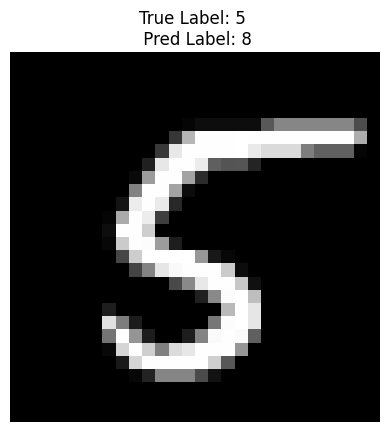

In [15]:
# Display random image
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
# Apply own softmax
y_pred = softmax(y_logits)


# Take the maximum array value
predicted_class = np.argmax(y_pred)

# Using mathplotlib, display the image
print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 9. Train Model
---

Using the train method defined in the Model class, perform mini-batch training by passing in the training and test datasets. This method should handle the full forward pass, loss computation, backpropagation, and weight updates across all epochs. From there, store the resulting metrics in a dictionary.

In [16]:
# Train model
metrics=model.train_minibatch(epochs=20, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=categorical_cross_entropy, metrics_fn=accuracy, learningRate=0.01)
losses=metrics["train_loss"]

Epoch: 0, Loss: 1.0878, Acc: 0.7829, Test Loss: 0.4908, Test Acc: 0.8746
Epoch: 1, Loss: 0.4203, Acc: 0.8867, Test Loss: 0.3703, Test Acc: 0.8978
Epoch: 2, Loss: 0.3505, Acc: 0.9017, Test Loss: 0.3251, Test Acc: 0.9081
Epoch: 3, Loss: 0.3179, Acc: 0.9093, Test Loss: 0.3015, Test Acc: 0.9143
Epoch: 4, Loss: 0.2956, Acc: 0.9160, Test Loss: 0.2834, Test Acc: 0.9173
Epoch: 5, Loss: 0.2767, Acc: 0.9221, Test Loss: 0.2662, Test Acc: 0.9227
Epoch: 6, Loss: 0.2602, Acc: 0.9259, Test Loss: 0.2537, Test Acc: 0.9273
Epoch: 7, Loss: 0.2452, Acc: 0.9315, Test Loss: 0.2400, Test Acc: 0.9319
Epoch: 8, Loss: 0.2318, Acc: 0.9353, Test Loss: 0.2287, Test Acc: 0.9348
Epoch: 9, Loss: 0.2194, Acc: 0.9387, Test Loss: 0.2201, Test Acc: 0.9373
Epoch: 10, Loss: 0.2083, Acc: 0.9419, Test Loss: 0.2111, Test Acc: 0.9408
Epoch: 11, Loss: 0.1982, Acc: 0.9446, Test Loss: 0.2037, Test Acc: 0.9433
Epoch: 12, Loss: 0.1887, Acc: 0.9479, Test Loss: 0.1953, Test Acc: 0.9451
Epoch: 13, Loss: 0.1800, Acc: 0.9494, Test Loss:

### 9.1 Plot Loss Curves

To gain insight and visualize how the model is learning, it's helpful to plot the training loss and accuracy over time. This can be done using libraries such as matplotlib. Visualizing these metrics allows you to assess convergence, detect overfitting, and evaluate model performance throughout training.

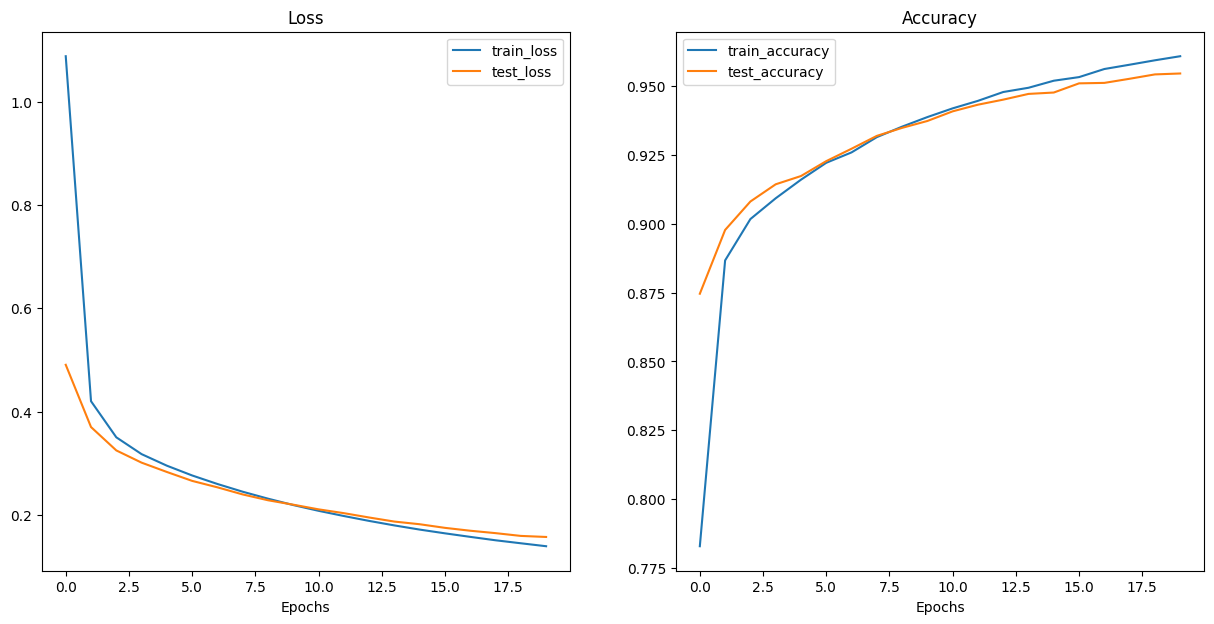

In [17]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_metrics"]
    test_accuracy = results["test_metrics"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(metrics)

### 9.2 Test Trained Prediction
After training, evaluate the model by making predictions on random images from the test set. The cell below can be run multiple times to see how well the model performs on different samples.

True label: 5, Predicted label: 5


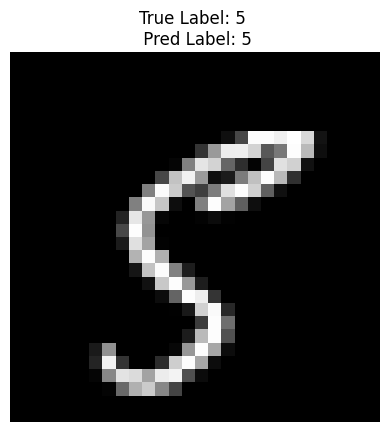

In [18]:
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)

predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 10. Build Confusion Matrix
---
The final step, to properly evaluate model performance, display the comparison of predicted values and actual values with a **confusion matrix**. A confusion matrix is an $N \times N$ table that summarizes the number of correct and incorrect predictions that a classification model made. For a multi-class classification problem it helps to identify patterns of mistakes. 

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Here in the confusion matrix, it can be clearly seen how much the model missclassifies, and how much it correctly classifies hand drawn digits

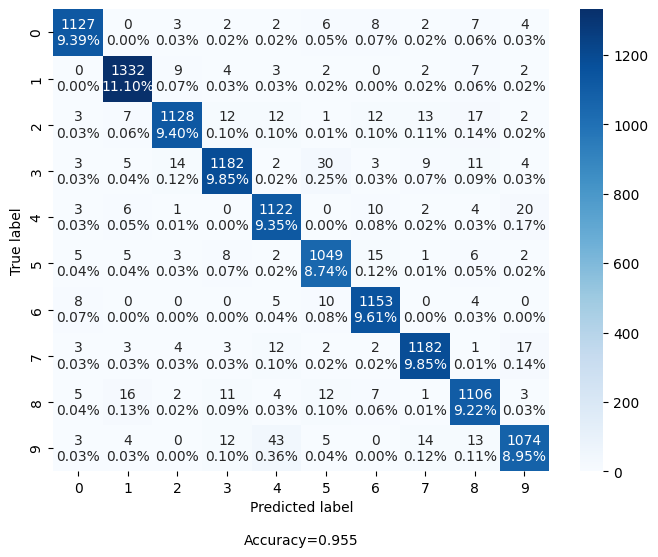

In [20]:
preds = softmax(model.ForwardProp(X_test))
y_true_cls = np.argmax(y_test, axis=1)
y_pred_cls = np.argmax(preds, axis=1)
cf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True,sum_stats=True)

## Credits
[Github- Mnist Dataset](https://github.com/cvdfoundation/mnist?tab=readme-ov-file)

[Dtuk - Confusion Matrix](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

[PapersWithCode - MNIST Dataset Explanation](https://paperswithcode.com/dataset/mnist)

[Google - One-hot encoding](https://developers.google.com/machine-learning/crash-course/categorical-data/one-hot-encoding)

[Google - Neural Network](https://developers.google.com/machine-learning/glossary#neural_network)

[Google - Activation Function](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/glossary)

[MachineLearningMastery - Gradient Descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)